# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 1000-2000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 


In [23]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 14:55:38.352700
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [24]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=1000
MAXLEN=2000   

In [25]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [26]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [27]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [28]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [29]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 14:55:41.138840
Load RCI values...
Num RCI: 13000
Example RCI: [('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]
Load genes...
2022-12-29 14:55:41.168352
Load sequence...
2022-12-29 14:55:51.415965
Num IDs: 13143
Example IDs: [('ENSG00000186827', 'ENST00000379236.4'), ('ENSG00000127054', 'ENST00000620829.4'), ('ENSG00000235098', 'ENST00000520296.5'), ('ENSG00000187730', 'ENST00000638411.1')]
Count 6959 ones out of 13143 labels.
Example labels: [0, 0, 0, 0]
Num counts: 13143
Example sequence: [60, 238, 182, 213, 81, 67, 11, 43, 171, 169, 164, 142, 54, 216, 95, 122, 229, 147, 75, 44, 175, 186, 229, 148, 78, 54, 216, 94, 118, 215, 89, 100, 142, 56, 223, 122, 231, 153, 98, 136, 31, 122, 230, 150, 87, 91, 107, 170, 168, 159, 122, 230, 151, 89, 97, 132, 13, 52, 206, 54, 216, 94, 118, 214, 86, 87, 91, 108, 175, 185, 225, 130, 6, 23, 91, 107, 171, 171, 170, 167, 155, 106, 168, 159, 123, 234, 165, 147, 73, 34, 133, 17, 67, 9, 35, 139, 41, 162,

## Model

In [30]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [31]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 14:55:51.450897
COMPILE
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 1997, 4)           1028      
                                                                 
 conv1d_12 (Conv1D)          (None, 1990, 64)          2112      
                                                                 
 global_average_pooling1d_12  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [32]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 14:55:51.599543
2022-12-29 14:55:51.599738
splitting
Fold 1
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10521, 1997) (10521, 1)
Valid sizes (2622, 1997) (2622, 1)
Train set ones/size 5609 / 10521
Valid set ones/size 1350 / 2622
BUILD MODEL
COMPILE
FIT
2022-12-29 14:55:53.353877
Epoch 1/5
329/329 [==============================] - 3s 6ms/step - loss: 0.6211 - accuracy: 0.6576 - val_loss: 0.6112 - val_accuracy: 0.6697
Epoch 2/5
329/329 [==============================] - 2s 5ms/step - loss: 0.5912 - accuracy: 0.6900 - val_loss: 0.5922 - val_accuracy: 0.6808
Epoch 3/5
329/329 [==============================] - 2s 5ms/step - loss: 0.5824 - accuracy: 0.6969 - val_loss: 0.5878 - val_accuracy: 0.6823
Epoch 4/5
329/329 [==============================] - 2s 6ms/step - loss: 0.5779 - accuracy: 0.7025 - val_loss: 0.5888 - val_accuracy: 0.6869
Epoch 5/5
329/329 [==============================] - 2s 5ms/step - loss: 0.5725 - accuracy: 0.7045 - val_loss: 0.5880 - val_accura

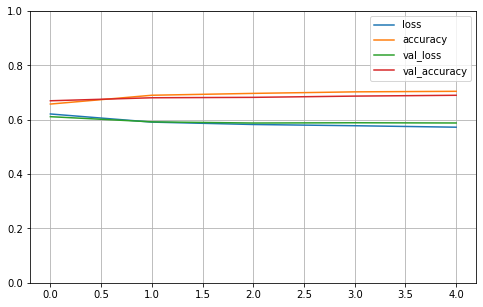

Compute valiation accuracy
2022-12-29 14:56:04.371151
Range of scores: 0.025384083 to 0.9646574
Predicted zeros and ones 1161 1461
Accuracy: 68.99% Precision: 68.38% Recall: 74.00% F1: 71.08%
2022-12-29 14:56:04.789046
Fold 2
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10474, 1997) (10474, 1)
Valid sizes (2669, 1997) (2669, 1)
Train set ones/size 5478 / 10474
Valid set ones/size 1481 / 2669
BUILD MODEL
COMPILE
FIT
2022-12-29 14:56:06.358964
Epoch 1/5
328/328 [==============================] - 3s 6ms/step - loss: 0.6193 - accuracy: 0.6592 - val_loss: 0.6007 - val_accuracy: 0.6767
Epoch 2/5
328/328 [==============================] - 2s 5ms/step - loss: 0.5891 - accuracy: 0.6938 - val_loss: 0.5996 - val_accuracy: 0.6815
Epoch 3/5
328/328 [==============================] - 2s 6ms/step - loss: 0.5800 - accuracy: 0.7039 - val_loss: 0.5957 - val_accuracy: 0.6782
Epoch 4/5
328/328 [==============================] - 2s 6ms/step - loss: 0.5744 - accuracy: 0.7107 - val_loss: 0.599

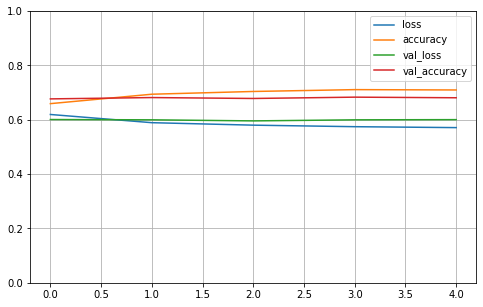

Compute valiation accuracy
2022-12-29 14:56:16.479902
Range of scores: 0.022760052 to 0.981344
Predicted zeros and ones 1112 1557
Accuracy: 68.08% Precision: 70.20% Recall: 73.80% F1: 71.96%
2022-12-29 14:56:16.762761
Fold 3
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10563, 1997) (10563, 1)
Valid sizes (2580, 1997) (2580, 1)
Train set ones/size 5669 / 10563
Valid set ones/size 1290 / 2580
BUILD MODEL
COMPILE
FIT
2022-12-29 14:56:18.318559
Epoch 1/5
331/331 [==============================] - 3s 6ms/step - loss: 0.6203 - accuracy: 0.6527 - val_loss: 0.6084 - val_accuracy: 0.6740
Epoch 2/5
331/331 [==============================] - 2s 5ms/step - loss: 0.5895 - accuracy: 0.6938 - val_loss: 0.6148 - val_accuracy: 0.6616
Epoch 3/5
331/331 [==============================] - 2s 6ms/step - loss: 0.5824 - accuracy: 0.7006 - val_loss: 0.6032 - val_accuracy: 0.6756
Epoch 4/5
331/331 [==============================] - 2s 6ms/step - loss: 0.5765 - accuracy: 0.7073 - val_loss: 0.6004

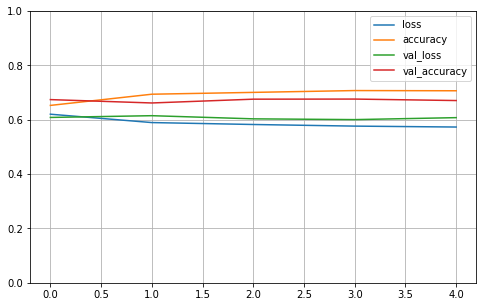

Compute valiation accuracy
2022-12-29 14:56:28.434354
Range of scores: 0.06185884 to 0.97271436
Predicted zeros and ones 1052 1528
Accuracy: 67.05% Precision: 64.40% Recall: 76.28% F1: 69.84%
2022-12-29 14:56:28.849077
Fold 4
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10478, 1997) (10478, 1)
Valid sizes (2665, 1997) (2665, 1)
Train set ones/size 5589 / 10478
Valid set ones/size 1370 / 2665
BUILD MODEL
COMPILE
FIT
2022-12-29 14:56:30.405612
Epoch 1/5
328/328 [==============================] - 3s 6ms/step - loss: 0.6231 - accuracy: 0.6482 - val_loss: 0.5994 - val_accuracy: 0.6912
Epoch 2/5
328/328 [==============================] - 2s 5ms/step - loss: 0.5948 - accuracy: 0.6835 - val_loss: 0.5893 - val_accuracy: 0.6979
Epoch 3/5
328/328 [==============================] - 2s 6ms/step - loss: 0.5874 - accuracy: 0.6894 - val_loss: 0.5824 - val_accuracy: 0.7073
Epoch 4/5
328/328 [==============================] - 2s 5ms/step - loss: 0.5828 - accuracy: 0.6923 - val_loss: 0.576

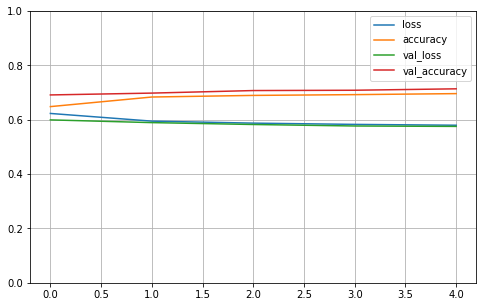

Compute valiation accuracy
2022-12-29 14:56:41.463111
Range of scores: 0.032923825 to 0.9706541
Predicted zeros and ones 1232 1433
Accuracy: 71.37% Precision: 71.18% Recall: 74.45% F1: 72.78%
2022-12-29 14:56:41.741314
Fold 5
Training example
[169 161 129 ...   0   0   0]
Train sizes (10536, 1997) (10536, 1)
Valid sizes (2607, 1997) (2607, 1)
Train set ones/size 5491 / 10536
Valid set ones/size 1468 / 2607
BUILD MODEL
COMPILE
FIT
2022-12-29 14:56:43.320000
Epoch 1/5
330/330 [==============================] - 3s 6ms/step - loss: 0.6278 - accuracy: 0.6476 - val_loss: 0.5783 - val_accuracy: 0.6981
Epoch 2/5
330/330 [==============================] - 2s 5ms/step - loss: 0.5990 - accuracy: 0.6857 - val_loss: 0.5839 - val_accuracy: 0.6958
Epoch 3/5
330/330 [==============================] - 2s 5ms/step - loss: 0.5905 - accuracy: 0.6935 - val_loss: 0.5794 - val_accuracy: 0.7062
Epoch 4/5
330/330 [==============================] - 3s 8ms/step - loss: 0.5837 - accuracy: 0.6925 - val_loss: 0.575

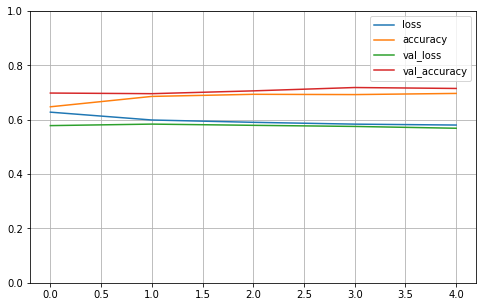

Compute valiation accuracy
2022-12-29 14:56:54.813603
Range of scores: 0.04718722 to 0.958388
Predicted zeros and ones 1044 1563
Accuracy: 71.50% Precision: 73.19% Recall: 77.93% F1: 75.49%
2022-12-29 14:56:55.229604

Cross validation 5 folds 5 epochs
 accuracy mean 69.40% +/- 1.77
 precision mean 69.47% +/- 2.97
 recall mean 75.29% +/- 1.58
 F1 mean 72.23% +/- 1.90
2022-12-29 14:56:55.235044


In [33]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())